### Görev 1 : Keşifçi Veri Analizi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [27]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("display.float_format",lambda x : "%.3f" % x)
pd.set_option("display.width",500)

In [4]:
df = pd.read_csv("diabetes.csv")

Adım 1: Genel resmi inceleyiniz.

In [29]:
def check_df(df,head=5):
    print("######################## SHAPE ##########################")
    print(df.shape)
    print("######################## TYPES ##########################")
    print(df.dtypes)
    print("######################## HEAD ##########################")
    print(df.head(head))
    print("######################## TAIL ##########################")
    print(df.tail(head))
    print("######################## NA ##########################")
    print(df.isnull().sum())



In [30]:
check_df(df)

######################## SHAPE ##########################
(768, 9)
######################## TYPES ##########################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
######################## HEAD ##########################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66  

Adım 2: Numerikvekategorikdeğişkenleriyakalayınız.

In [8]:
def grab_col_names(df,cat_th=10,car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtypes  == "O"]
    num_but_cat = [col for col in df.columns if df[col].dtypes != "O" and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() > car_th ]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_car: {len(num_but_cat)}")
    return cat_cols,num_cols,cat_but_car

In [9]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_car: 1


In [10]:
cat_cols

['Outcome']

In [11]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

Adım 3:  Numerik ve kategorik değişkenlerin analizini yapınız.

In [31]:
def cat_summary(df, col_name,plot=False):
    print(pd.DataFrame({col_name : df[col_name].value_counts(),
                       "Ratio":100*df[col_name].value_counts()/ len(df) }))
    print("*********************************")
    if plot:
        sns.countplot(x=df[col_name], data=df)
        plt.show()

In [32]:
cat_summary(df,"Outcome")

   Outcome  Ratio
0      500 65.104
1      268 34.896
*********************************


In [33]:
def num_summary(df,num_cols,plot=False):
    print(df[num_cols].describe().T)
    if plot:
        df[num_cols].hist()
        plt.xlabel(num_cols)
        plt.title(num_cols)
        plt.show()

count   768.000
mean      3.845
std       3.370
min       0.000
25%       1.000
50%       3.000
75%       6.000
max      17.000
Name: Pregnancies, dtype: float64


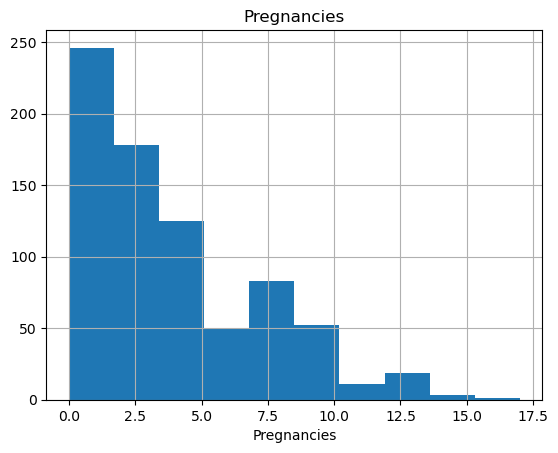

None
count   768.000
mean    120.895
std      31.973
min       0.000
25%      99.000
50%     117.000
75%     140.250
max     199.000
Name: Glucose, dtype: float64


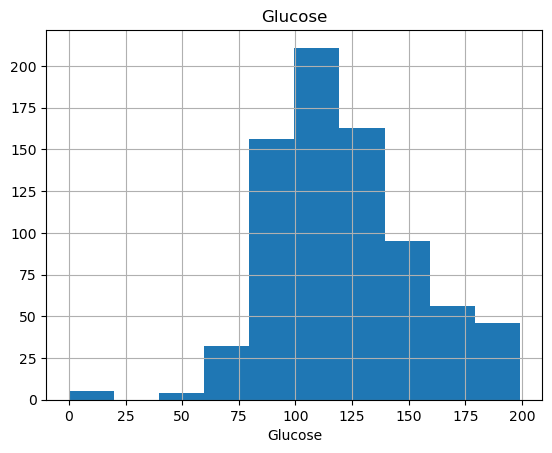

None
count   768.000
mean     69.105
std      19.356
min       0.000
25%      62.000
50%      72.000
75%      80.000
max     122.000
Name: BloodPressure, dtype: float64


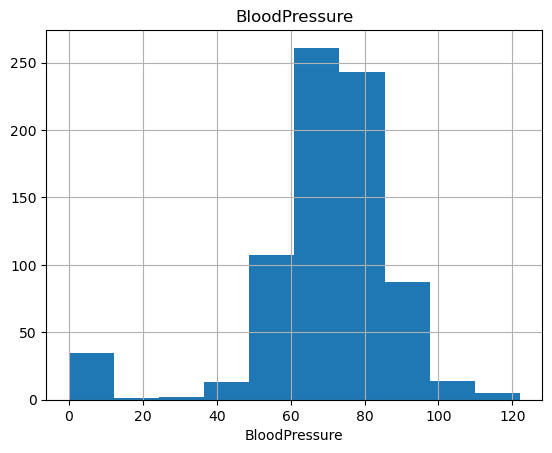

None
count   768.000
mean     20.536
std      15.952
min       0.000
25%       0.000
50%      23.000
75%      32.000
max      99.000
Name: SkinThickness, dtype: float64


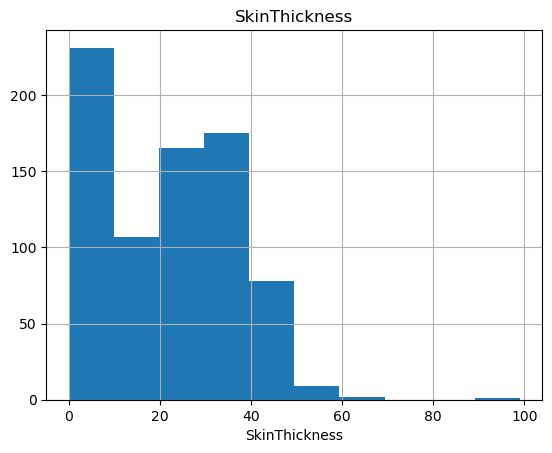

None
count   768.000
mean     79.799
std     115.244
min       0.000
25%       0.000
50%      30.500
75%     127.250
max     846.000
Name: Insulin, dtype: float64


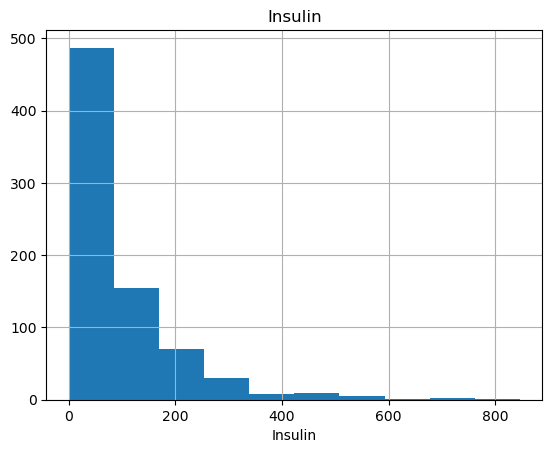

None
count   768.000
mean     31.993
std       7.884
min       0.000
25%      27.300
50%      32.000
75%      36.600
max      67.100
Name: BMI, dtype: float64


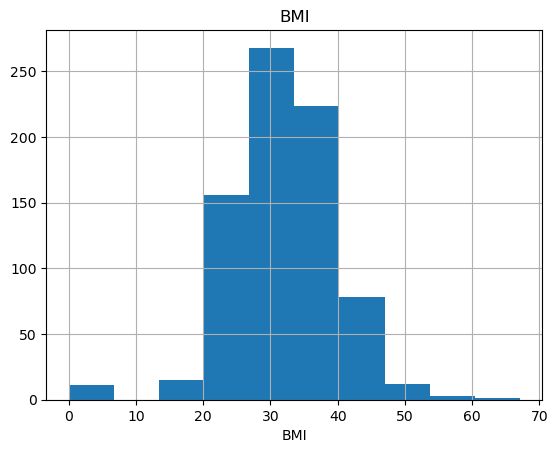

None
count   768.000
mean      0.472
std       0.331
min       0.078
25%       0.244
50%       0.372
75%       0.626
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


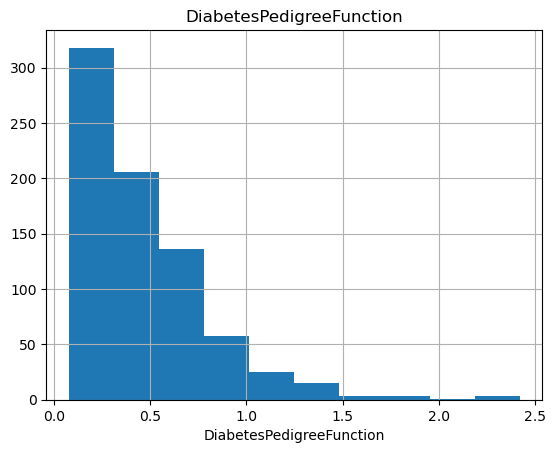

None
count   768.000
mean     33.241
std      11.760
min      21.000
25%      24.000
50%      29.000
75%      41.000
max      81.000
Name: Age, dtype: float64


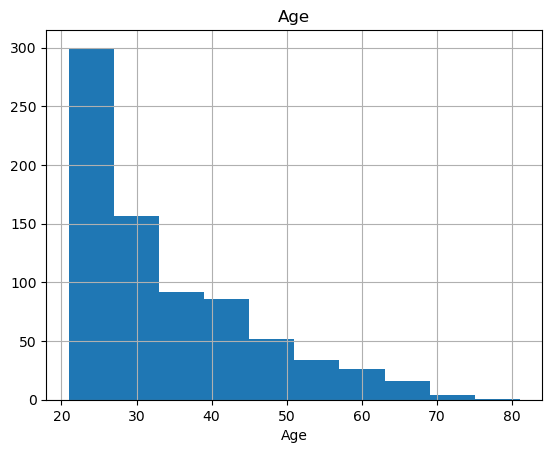

None


In [35]:
for col in num_cols:
    print(num_summary(df,col,True))

Adım 4:Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)

In [19]:
for col in cat_cols:
    print(df.groupby("Outcome").agg({col: "mean"}))

         Outcome
Outcome         
0            0.0
1            1.0


In [18]:
for col in num_cols:
    print(df.groupby("Outcome").agg({col : "mean"}))
    print("\n")

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




Adım 5: Aykırı gözlem analizi yapınız.

In [20]:
def outlier_thresholds(df,col,q1=0.25,q3=0.75):
    quartile1 = df[col].quantile(q1)
    quartile3 = df[col].quantile(q3)
    interquantiler_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantiler_range
    low_limit = quartile1 - 1.5 * interquantiler_range
    return low_limit,up_limit

In [21]:
def check_outlier(df,col):
    low_limit,up_limit = outlier_thresholds(df,col)
    if df[(df[col]>up_limit) | (df[col]< low_limit)].any(axis=None):
        return True
    else:
        return False

In [46]:
def replace_with_thresholds(df,col):
    low_limit,up_limit = outlier_thresholds(df,col)
    df.loc[(df[col] < low_limit),col] = low_limit
    df.loc[(df[col] > up_limit),col] = up_limit


In [48]:
for col in num_cols:
    print(col,check_outlier(df,col))
    if check_outlier(df,col):
        replace_with_thresholds(df,col)

Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


In [49]:
for col in num_cols:
    print(col,check_outlier(df,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


Adım 6: Eksik gözlem analizi yapınız.

In [23]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [24]:
df.notnull().sum()

Pregnancies                 768
Glucose                     768
BloodPressure               768
SkinThickness               768
Insulin                     768
BMI                         768
DiabetesPedigreeFunction    768
Age                         768
Outcome                     768
dtype: int64

Adım 7: Korelasyon analizi yapınız.

In [25]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


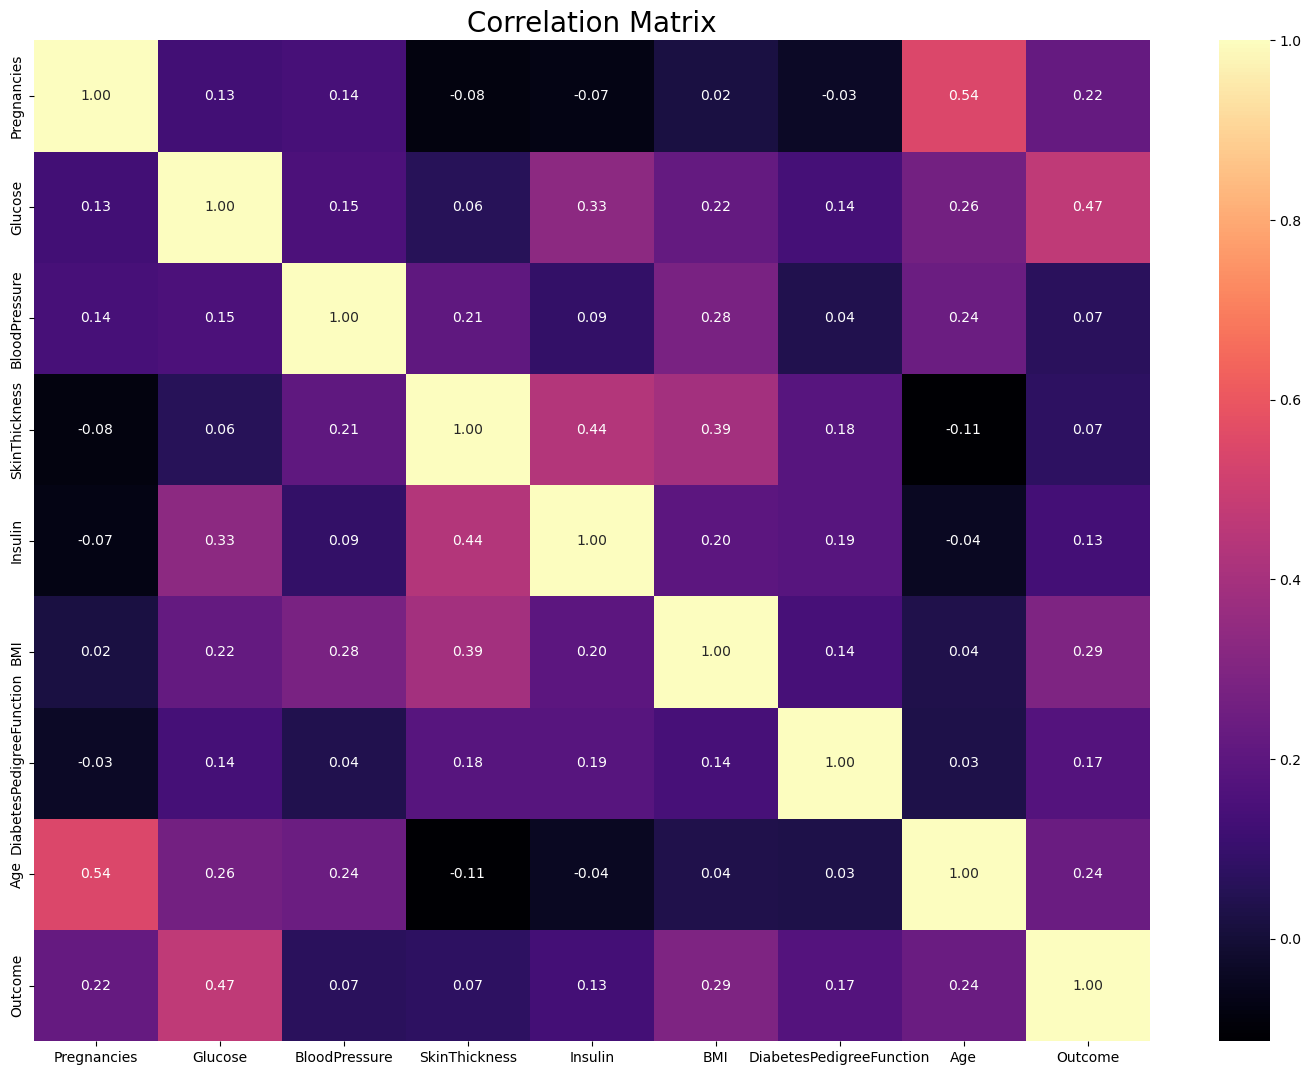

In [36]:
f, ax = plt.subplots(figsize=[18,13])
sns.heatmap(df.corr(),annot=True,fmt=".2f",ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show(block=True)

### Görev 2 : Feature Engineering

Adım 1:  Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb. değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri 0 olamayacaktır. Bu durumudikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik değerlere işlemleri uygulayabilirsiniz.

In [38]:
zero_columns = [col for col in df.columns if(df[col].min() == 0 and col not in ["Pregnancies","Outcome"])]

In [39]:
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [40]:
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [41]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [42]:
def missing_values_table(df,na_name=False):
    na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (df[na_columns].isnull().sum() / df.shape[0] *100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss,np.round(ratio,2)],axis=1,keys=["n_miss","ratio"])
    print(missing_df,end="\n" )
    if na_name:
        return na_columns

In [43]:
na_columns = missing_values_table(df,na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [44]:
for col in zero_columns:
    df.loc[df[col].isnull(),col] = df[col].median()

In [45]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Adım 2: Yeni değişkenler oluşturunuz.

In [50]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkenleri oluşturulması

In [51]:
df.loc[(df["Age"] >= 21) & (df["Age"] < 50),"NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50),"NEW_AGE_CAT"] = "senior"

In [53]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez

In [55]:
df["NEW_BMI"] = pd.cut(x=df["BMI"], bins=[0,18.5,24.9,29.9,100],labels=["Underwight","Healthy","Overweight","Obese"])

In [56]:
#Glukoz değerini kategorik değişkene çevirme

In [58]:
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0,140,200,300],labels=["Normal","Prediabetes","Diabetes"])

In [ ]:
#Yaş ve beden kitle indekisni bir arada düşünerek kategorik değişken oluşturma

In [60]:
df["NEW_AGE_BMI_NOM"] =  ["".join(i) for i in df[["NEW_BMI","NEW_AGE_CAT"]].values]

In [61]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Prediabetes,Obesesenior
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,Overweightmature
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Prediabetes,Healthymature
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,mature,Overweight,Normal,Overweightmature
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,mature,Obese,Normal,Obesemature


In [62]:
#Yaş ve glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma

In [63]:
df["NEW_AGE_GLUCOSE_NOM"] =  ["".join(i) for i in df[["NEW_GLUCOSE","NEW_AGE_CAT"]].values]

In [64]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Prediabetes,Obesesenior,Prediabetessenior
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,Overweightmature,Normalmature
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Prediabetes,Healthymature,Prediabetesmature
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,mature,Overweight,Normal,Overweightmature,Normalmature
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,mature,Obese,Normal,Obesemature,Normalmature


In [65]:
#İnsülin değeri ile kategorik değişken üretmek

In [66]:
def set_insulin(df,col="Insulin"):
    if 16<= df[col]  <= 166:
        return "Normal"
    else:
        return "Anormal"

In [67]:
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin,axis=1)

In [68]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

In [69]:
df.columns = [col.upper() for col in df.columns]

In [70]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Prediabetes,Obesesenior,Prediabetessenior,Normal,18500.000
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,Overweightmature,Normalmature,Normal,10625.000
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Prediabetes,Healthymature,Prediabetesmature,Normal,22875.000
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,mature,Overweight,Normal,Overweightmature,Normalmature,Normal,10045.875
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,mature,Obese,Normal,Obesemature,Normalmature,Normal,18614.875


Adım 3:  Encoding işlemlerini gerçekleştiriniz.

In [71]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)

Observations: 768
Variables: 16
cat_cols: 7
num_cols: 9
cat_but_car: 0
num_but_car: 3


In [72]:
def label_encoder(df,binary_col):
    le = LabelEncoder()
    df[binary_col] = le.fit_transform(df[binary_col])
    return df

In [73]:
binary_cols = [col for col in df.columns if df[col].dtype not in ["int64","float64"] and df[col].nunique() == 2]

In [74]:
binary_cols

['NEW_AGE_CAT', 'NEW_GLUCOSE']

In [75]:
for col in binary_cols:
    df = label_encoder(df,col)

In [76]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,Obese,1,Obesesenior,Prediabetessenior,Normal,18500.000
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,Overweight,0,Overweightmature,Normalmature,Normal,10625.000
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,Healthy,1,Healthymature,Prediabetesmature,Normal,22875.000
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,0,Overweight,0,Overweightmature,Normalmature,Normal,10045.875
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0,Obese,0,Obesemature,Normalmature,Normal,18614.875


In [77]:
def one_hot_encoder(df,categorical_cols,drop_first=True):
    df = pd.get_dummies(df,columns=categorical_cols,drop_first=drop_first)
    return df

In [79]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]

In [80]:
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_INSULIN_SCORE', 'NEW_BMI']

In [81]:
df = one_hot_encoder(df,cat_cols,drop_first=True)

In [82]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE,NEW_GLUCOSE*INSULIN,NEW_AGE_BMI_NOM_Healthysenior,NEW_AGE_BMI_NOM_Obesemature,NEW_AGE_BMI_NOM_Obesesenior,NEW_AGE_BMI_NOM_Overweightmature,NEW_AGE_BMI_NOM_Overweightsenior,NEW_AGE_BMI_NOM_Underwightmature,NEW_AGE_GLUCOSE_NOM_Normalsenior,NEW_AGE_GLUCOSE_NOM_Prediabetesmature,NEW_AGE_GLUCOSE_NOM_Prediabetessenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,1,18500.000,0,0,1,0,0,0,0,0,1,0,0,1
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,0,10625.000,0,0,0,1,0,0,0,0,0,0,1,0
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,1,22875.000,0,0,0,0,0,0,0,1,0,1,0,0
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,0,0,10045.875,0,0,0,1,0,0,0,0,0,0,1,0
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0,0,18614.875,0,1,0,0,0,0,0,0,0,0,0,1


Adım 4: Numerik değişkenler için standartlaştırma yapınız.

In [83]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN']

In [86]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [87]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE,NEW_GLUCOSE*INSULIN,NEW_AGE_BMI_NOM_Healthysenior,NEW_AGE_BMI_NOM_Obesemature,NEW_AGE_BMI_NOM_Obesesenior,NEW_AGE_BMI_NOM_Overweightmature,NEW_AGE_BMI_NOM_Overweightsenior,NEW_AGE_BMI_NOM_Underwightmature,NEW_AGE_GLUCOSE_NOM_Normalsenior,NEW_AGE_GLUCOSE_NOM_Prediabetesmature,NEW_AGE_GLUCOSE_NOM_Prediabetessenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese
0,0.647,0.866,-0.031,0.825,0.039,0.181,0.589,1.446,1,1,1,0.750,0,0,1,0,0,0,0,0,1,0,0,1
1,-0.849,-1.205,-0.544,0.018,0.039,-0.869,-0.378,-0.189,0,0,0,-1.078,0,0,0,1,0,0,0,0,0,0,1,0
2,1.246,2.017,-0.715,0.018,0.039,-1.365,0.747,-0.103,1,0,1,1.766,0,0,0,0,0,0,0,1,0,1,0,0
3,-0.849,-1.074,-0.544,-0.789,-1.494,-0.644,-1.023,-1.050,0,0,0,-1.212,0,0,0,1,0,0,0,0,0,0,1,0
4,-1.148,0.504,-2.768,0.825,1.414,1.607,2.597,-0.017,1,0,0,0.777,0,1,0,0,0,0,0,0,0,0,0,1


Adım 5: Model oluşturunuz.

In [93]:
y = df["OUTCOME"]
X= df.drop("OUTCOME",axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=17)

In [94]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

In [102]:
print(f"Accuracy : {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall : {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision : {round(precision_score(y_pred, y_test), 2)}")
print(f"F1 : {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc : {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy : 0.79
Recall : 0.732
Precision : 0.64
F1 : 0.68
Auc : 0.78


### Feature Importance

In [104]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value" : model.feature_importances_ , "Feature" : features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value",y="Feature",data=feature_imp.sort_values(by="Value",ascending=False)[0:num])

    plt.title("Features")
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig("importances.png")

    Value                                Feature
10  0.177                    NEW_GLUCOSE*INSULIN
1   0.145                                GLUCOSE
7   0.110                                    AGE
5   0.103                                    BMI
6   0.095               DIABETESPEDIGREEFUNCTION
0   0.079                            PREGNANCIES
2   0.063                          BLOODPRESSURE
3   0.062                          SKINTHICKNESS
4   0.040                                INSULIN
18  0.031  NEW_AGE_GLUCOSE_NOM_Prediabetesmature
9   0.029                            NEW_GLUCOSE
22  0.012                          NEW_BMI_Obese
20  0.010                        NEW_BMI_Healthy
12  0.008            NEW_AGE_BMI_NOM_Obesemature
21  0.006                     NEW_BMI_Overweight
14  0.006       NEW_AGE_BMI_NOM_Overweightmature
8   0.005                            NEW_AGE_CAT
15  0.005       NEW_AGE_BMI_NOM_Overweightsenior
13  0.004            NEW_AGE_BMI_NOM_Obesesenior
17  0.004       NEW_

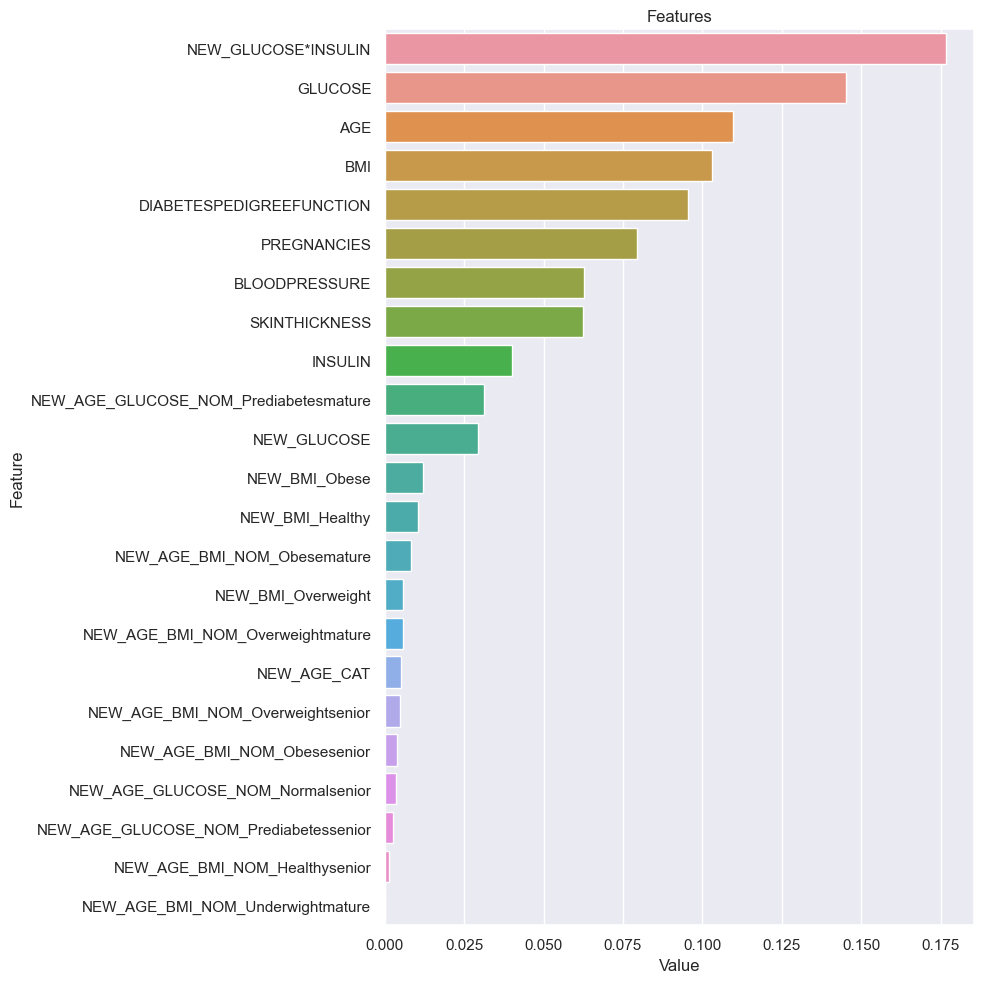

In [105]:
    plot_importance(rf_model,X)